In [1]:
import pandas as pd
import numpy as np
import os
import shutil

import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error


from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from scipy.stats import kstest, shapiro




In [81]:
# Read CSV and drop redundant columns

df = pd.read_csv('master_data_frame.csv')
df_copy = df.copy()
df_copy = df_copy.drop('Unnamed: 0',axis=1) 


to_drop = ['temp_anode_inlet_set', 'temp_cathode_inlet_set', 'pressure_anode_set',
           'pressure_cathode_set', 'flow_anode_di_water_supply_set', 'flow_cathode_di_water_supply_set', 
          'flow_cathode_di_water_supply', 'signal_in_o2_in_h2_sensor']

df_copy = df_copy.drop(to_drop, axis=1)




# agregate into different time quanta?


df_copy['minutes'] = ((df_copy['time_running_total']/1000)/60).astype(int)
df_copy['hours'] = (df_copy['minutes']/60).astype(int)
df_copy['days'] = (df_copy['hours']/24).astype(int)
df_copy['weeks'] = (df_copy['days']/7).astype(int)
df_copy = df_copy.drop('time_running_total',axis=1)

df_copy


,cell_voltage_001,current,current_density,temp_anode_inlet,temp_anode_outlet,temp_cathode_inlet,temp_cathode_outlet,pressure_anode_inlet,pressure_anode_outlet,pressure_cathode_inlet,pressure_cathode_outlet,flow_anode_di_water_supply,signal_in_resistivity_anode,signal_in_resistivity_cathode,signal_in_h2_in_o2_sensor,minutes,hours,days,weeks
0,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0,0,0
1,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0,0,0
2,-0.095167,-0.01262,-0.000505,22.524658,22.211363,22.943993,22.664978,0.015911,-0.026205,-0.009285,-0.009439,0.149858,0.142337,0.580925,0.278146,0,0,0,0
3,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,0,0,0,0
4,-0.095167,-0.01192,-0.000477,23.574999,22.622944,22.930300,22.651320,0.184089,-0.026205,-0.009285,-0.001021,0.270174,0.132591,0.585798,0.276583,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461237,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,82242,1370,57,8
461238,1.879790,75.00482,3.000193,79.819145,78.329117,29.627552,34.574463,1.992006,1.723834,6.002450,6.019177,0.300858,0.230055,0.152083,0.104703,82242,1370,57,8
461239,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,82243,1370,57,8
461240,1.880171,75.00482,2.999912,79.819145,78.354111,29.627552,34.560806,1.992006,1.723834,6.002450,5.960248,0.300858,0.215435,0.156957,0.103140,82243,1370,57,8


58582


,signal_in_h2_in_o2_sensor,minutes
3289,0.106265,3360
3290,0.106265,3361
3291,0.106265,3362
3292,0.106265,3363
3293,0.106265,3364
...,...,...
73259,0.101265,82239
73260,0.103140,82240
73261,0.103140,82241
73262,0.103765,82242


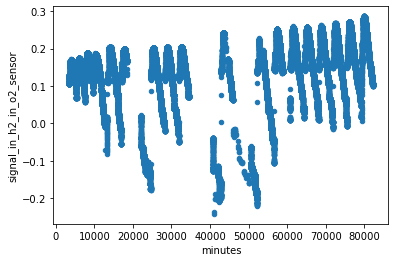

In [83]:
# time range selection

time_period = 'minutes'



df_time = df_copy.groupby(time_period).mean().reset_index()

df_time =df_time.loc[df_time['hours'] > 55]

df_time =df_time.loc[df_time['current_density'] > 0]


# df_time =df_time.loc[df_time['signal_in_h2_in_o2_sensor'] > 0]

df_time.reset_index().plot(kind='scatter', x =time_period, y='signal_in_h2_in_o2_sensor')

print(len(df_time))

df_time



# df_time.reset_index(inplace=True)
# df_time = df_time.drop('index',axis=1)
# df_time = df_time.drop(['minutes','hours', 'days', 'weeks'],axis=1)

df_time = df_time[['signal_in_h2_in_o2_sensor', 'minutes']]


df_time

<AxesSubplot:xlabel='minutes', ylabel='signal_in_h2_in_o2_sensor'>

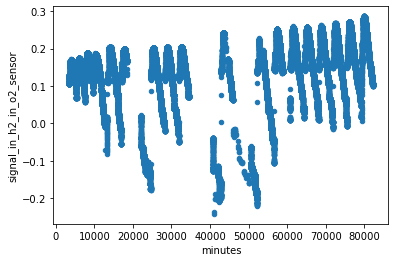

In [79]:
df_time['signal_in_h2_in_o2_sensor'] = df_time['signal_in_h2_in_o2_sensor'].fillna(df_time['signal_in_h2_in_o2_sensor'].rolling(3, min_periods=1).mean())



df_time.plot(kind='scatter', x='minutes', y='signal_in_h2_in_o2_sensor')


In [84]:
df_time[df_time['signal_in_h2_in_o2_sensor'] == 0 ]

,signal_in_h2_in_o2_sensor,minutes


In [86]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58582 entries, 3289 to 73263
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   signal_in_h2_in_o2_sensor  58582 non-null  float64
 1   minutes                    58582 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.3 MB


In [73]:
df_time

,signal_in_h2_in_o2_sensor,minutes
3289,0.106265,3360
3290,0.106265,3361
3291,0.106265,3362
3292,0.106265,3363
3293,0.106265,3364
...,...,...
73259,0.101265,82239
73260,0.103140,82240
73261,0.103140,82241
73262,0.103765,82242
